# Simple Modelling Notebook: 

This notebook contains most of my experiments and observations. 

Some models have been removed for clarity. These include statistical models which ran very slowly and did not perform well. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler



##### Here are just some useful functions and holiday data for later use

In [2]:
# Create a list of UK holidays
uk_holidays = holidays.UnitedKingdom()
holidays_list = [date for date, name in uk_holidays.items()]

def clean_column_names(columns: pd.Index) -> pd.Series:
    """Clean column names by removing quotes, converting to lowercase, and replacing spaces with underscores."""
    return (pd.Series(columns)
            .str.replace('"', '', regex=False)
            .str.lower()
            .str.replace(' ', '_', regex=False)
    )

def fill_missing_with_previous_mean(df: pd.Series, days_to_average: int = 7) -> pd.Series:
    """Fill missing values using the mean of the same time of day over the last N days."""
    grouped_df = df.groupby(df.index.time)
    mean_over_days = grouped_df.transform(lambda x: x.rolling(window=days_to_average, min_periods=1).mean())
    return mean_over_days

def create_date_time_features(df: pd.DataFrame, use_holiday: bool = False) -> pd.DataFrame:
    """Create time-series features based on the DataFrame's datetime index."""
    df = df.copy()
    df["minute"] = df.index.minute
    df["hour"] = df.index.hour
    # df["dayofweek"] = df.index.day_of_week  # Monday 0, Sunday 6
    # df["isweekend"] = df.index.dayofweek > 4

    if use_holiday:
        df["is_holiday"] = df.index.isin(holidays_list)
    return df

def one_hot_encode_cols(df: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode specified categorical columns in the DataFrame."""
    df = df.copy()
    cols_to_ohe = ["minute",
                    "hour", 
                    # "dayofweek", 
                    # "isweekend",
                    # "is_holiday"
                    ]
    df = pd.get_dummies(df, columns=cols_to_ohe, drop_first=False)
    return df


##### Loading Data and dealing with NaN values again: 

In [3]:
data_df = pd.read_csv("../data/data.csv", index_col="from")
data_df.columns = clean_column_names(data_df.columns)

# Convert Date to Date-Time Object + Remove Timezone info:
data_df.index.name = "Date"
data_df.index = pd.to_datetime(data_df.index)
data_df.index = data_df.index.tz_localize(None)


# Fill NaN values: 
data_df["carbon_intensity_actual"] = data_df["carbon_intensity_actual"].fillna(data_df["carbon_intensity_forecast"])


# Number of days to average
n_days = 3
for column in ['solar', 'wind_onshore', 'wind_offshore']:
   data_df[column] = data_df[column].fillna(
       fill_missing_with_previous_mean(data_df[column], days_to_average=n_days)
   )



rmse = root_mean_squared_error(data_df["carbon_intensity_actual"], data_df["carbon_intensity_forecast"])
mae = mean_absolute_percentage_error(data_df["carbon_intensity_actual"], data_df["carbon_intensity_forecast"])
print(f"RMSE of current Forecast is {rmse.item():.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error of current Forecast is {mae.item() * 100:.3}%.")

# We can now drop the forecast column:
data_df = data_df.drop(columns=["carbon_intensity_forecast"])


RMSE of current Forecast is 13.542 gCO₂/kWh.
Mean Absolute Percentage Error of current Forecast is 6.41%.


So here is the value we for accuracy we would like to match. Dont forget that this one is slightly biased as we imputed the missng values with the forecasts. For simplicity lets keep this one. 

## Splitting the data into train and test splits: 

Lets keep the last 2 months for our test predictions. 

In [4]:
# First of November split date:
split_date = "2022-11-01"
train_data = data_df[data_df.index < split_date]
test_data = data_df[data_df.index >= split_date]

## Setup Cross-Validation: 

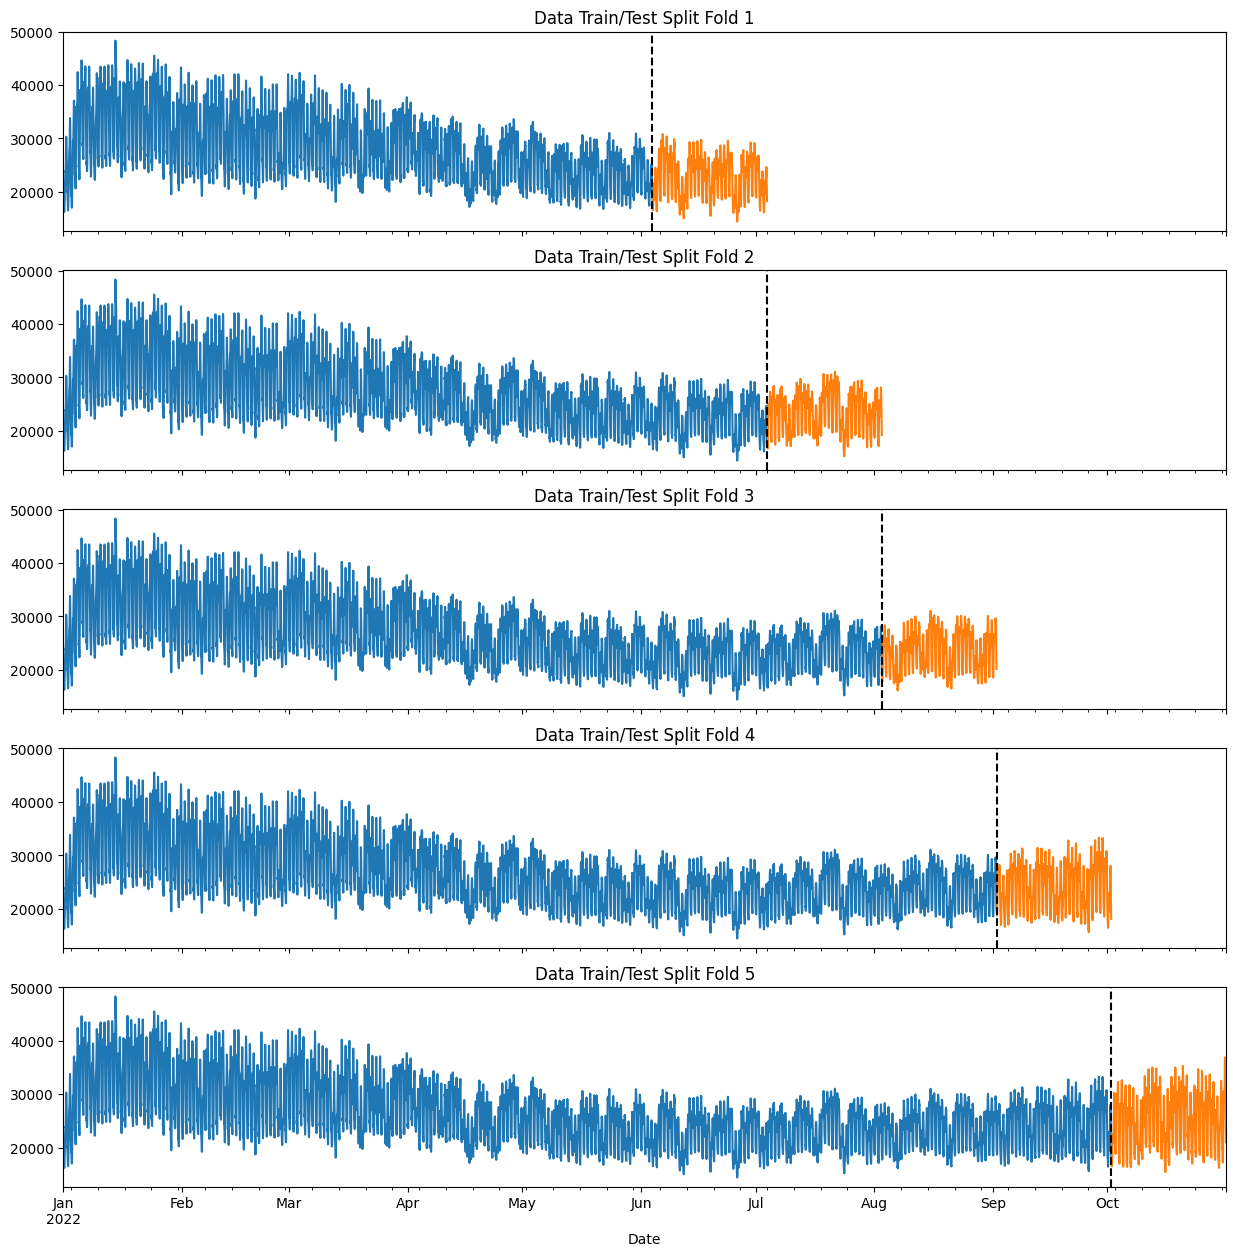

In [5]:
# test size of 1 month = 48 values in 1 day and month has 30 days:
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    test = train_data.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold + 1}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

##  Initial Benchmark Models: 

The task we have here is predicting next day carbon intensity - 24hours and 30 minute intervals. This task is known as regression as we are looking to predict a continuous value. 

We can use information we have about forecasted demand and energy production for our predictions, which makes our problem a multivariate timeseries problem. 

- There are lots of different models one could used for multivariate timeseries prediction. They include statistical models such as ARIMA and SARIMA, as well as neural networks such as LSTMs.
- We can also simply use a powerful regression model such as XGBoost for our predictions. 


In this notebook, we will run multiple experiments: 

1. Naive next-day guess using previous day's values
2. Using the XGBoost ensemble model

Next we will look at the effect of different features: 
1. Adding date-time features
2. Adding holidays
3. Adding Lag values - Data from previous days/weeks
4. Finally we will look into including extra data such as forecasted mix of fuels used for the grid. 

## 1. Naive next day prediction: 

Although a very naive benchmark, there could be some similarities. 

Our downsteam models should at least beat this benchmark. 


- Using past day's results for prediction: 



RMSE of current Forecast is 48.436 gCO₂/kWh.
Mean Absolute Percentage Error of current Forecast is 24.3%.


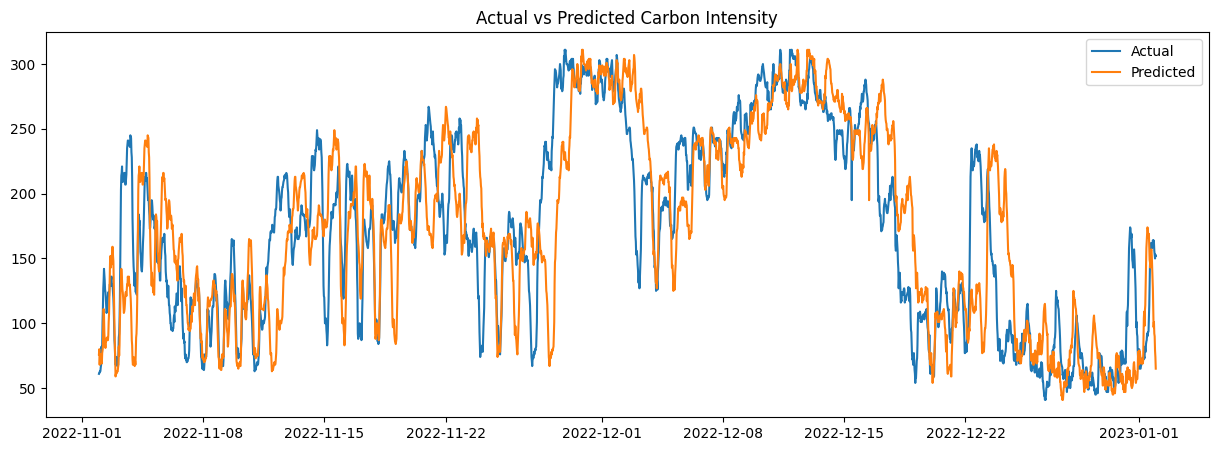

In [ ]:
train_data = data_df[data_df.index < split_date].copy()
test_data = data_df[data_df.index >= split_date].copy()

# Shifting by 48 values as there are 48 values in 1 day:
test_data['carbon_intensity_prediction'] = test_data['carbon_intensity_actual'].shift(48)
test_data = test_data.dropna()  # As we are using past days, we have to drop the first 48 values

rmse = root_mean_squared_error(test_data["carbon_intensity_actual"], test_data["carbon_intensity_prediction"])
mae = mean_absolute_percentage_error(test_data["carbon_intensity_actual"], test_data["carbon_intensity_prediction"])

print(f"RMSE of current Forecast is {rmse.item():.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error of current Forecast is {mae.item() * 100:.3}%.")


# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, test_data["carbon_intensity_prediction"], label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()

- Although the Mean Absolute percentage error is around 24%, when looking at the predictions clearly, we can notice how bad they are. This could never be used on the grid. We need much more accurate results on small timeframes. 

- We are not using any extra features for this too. We could be using much more information for our predictions. 

- Good baseline to beat. 



## 2. XGBoost regressor:

XGBoost is a gradient boosted tree. An ensemble model which performs very well on a wide array of tasks. 

- In this example model, we will be using the forecasts we are given for demand, solar energy, and wind production estimates which could be from accurate models. 
- We will be doing a regression for the Carbon Intensity. Although XGBoost does not require normalisation, it is still good practice, as certain features may be on different scales and lead to higher perceived importance. 


XGBoost has lots of hyperparameters, in our case we will keep them simple with: 
- 100 estimators



In [7]:
train_data = data_df[data_df.index < split_date].copy()
test_data = data_df[data_df.index >= split_date].copy()


fold = 0
preds = []
scores = []
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)


# Normalise the features in train_data
scaler = StandardScaler()

for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    val = train_data.iloc[val_idx]

    X_train, y_train = train.drop(columns=["carbon_intensity_actual"]), train["carbon_intensity_actual"]
    X_val, y_val = val.drop(columns=["carbon_intensity_actual"]), val["carbon_intensity_actual"]
    
    # Normalize the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)


    reg = xgb.XGBRegressor( 
                           n_estimators=100, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           early_stopping_rounds=50,
                           eval_metric="rmse",
                           reg_alpha=0.1,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )
    

    reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), 
                      (X_val, y_val)], 
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)
    print(f"Fold {fold + 1}, RMSE: {score:.5}")


print(f"Mean of cross validation RMSE is {np.mean(scores):.5} gCO₂/kWh.")

[0]	validation_0-rmse:62.97374	validation_1-rmse:52.40199
[84]	validation_0-rmse:19.99856	validation_1-rmse:26.66521
Fold 1, RMSE: 25.388
[0]	validation_0-rmse:61.40339	validation_1-rmse:56.72646
[99]	validation_0-rmse:20.19220	validation_1-rmse:31.73151
Fold 1, RMSE: 31.679
[0]	validation_0-rmse:60.60186	validation_1-rmse:58.55360
[99]	validation_0-rmse:21.15726	validation_1-rmse:25.62072
Fold 1, RMSE: 25.621
[0]	validation_0-rmse:60.10668	validation_1-rmse:63.08319


[99]	validation_0-rmse:21.08420	validation_1-rmse:36.97455
Fold 1, RMSE: 36.96
[0]	validation_0-rmse:60.37907	validation_1-rmse:62.33083
[99]	validation_0-rmse:22.60705	validation_1-rmse:27.39982
Fold 1, RMSE: 27.153
Mean of cross validation RMSE is 29.36 gCO₂/kWh.


After some minor HP tuning, let's stick with the following for our predictions: 

- 1_000 estimators - 100 different trees
- Maximum Depth of 5
- Some L1 and L2 regularisation



### Now lets retrain on the whole train set and see how good our results are for this initial benchmark: 




RMSE on test set is 34.001 gCO₂/kWh.
Mean Absolute Percentage Error on test set is 21.9%.


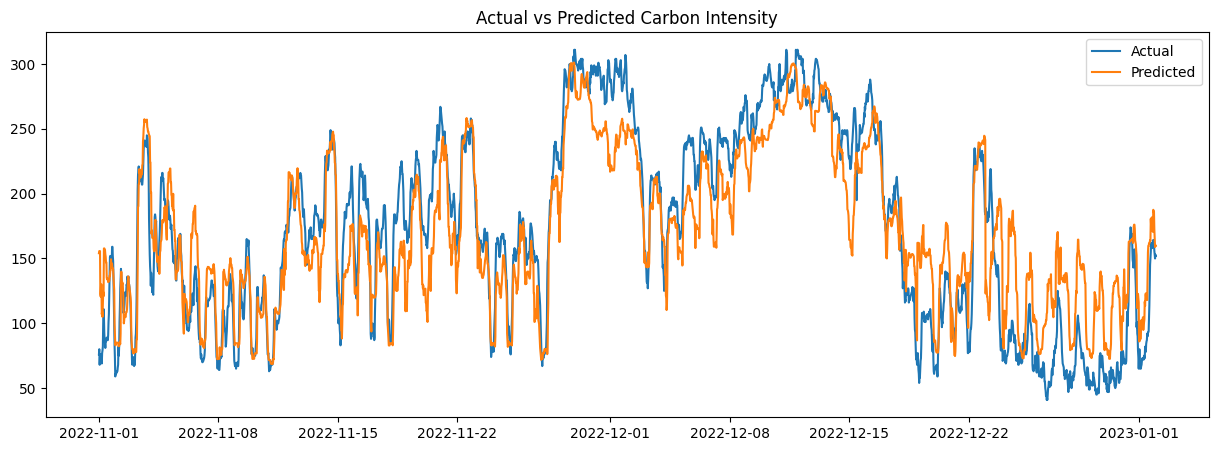

In [8]:
train_data = data_df[data_df.index < split_date].copy()
test_data = data_df[data_df.index >= split_date].copy()


X_train, y_train = train_data.drop(columns=["carbon_intensity_actual"]), train_data["carbon_intensity_actual"]
X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]


# Normalize the features:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


reg = xgb.XGBRegressor( 
                        n_estimators=100, 
                        max_depth=5, 
                        learning_rate=0.05, 
                        random_state=123, 
                        # early_stopping_rounds=50,
                        eval_metric="rmse",
                        reg_alpha=0.1,  # L1 regularization
                        reg_lambda=0.01   # L2 regularization
                        )

reg = reg.fit(X_train, y_train,
                verbose=None,
)


predictions = reg.predict(X_test)
score = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test set is {score:.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error on test set is {mape*100:.3}%.")

# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()




Great so we now have an actual working model with a decent benchmark. 

This model has an RMS error of around 34 gCO₂/kWh which is not bad. This amounts to a Mean Absolute Percentage error of around 22%. 

When looking closer at the plot, we can notice that the model understands the global landscape of the actual carbon intensity. 

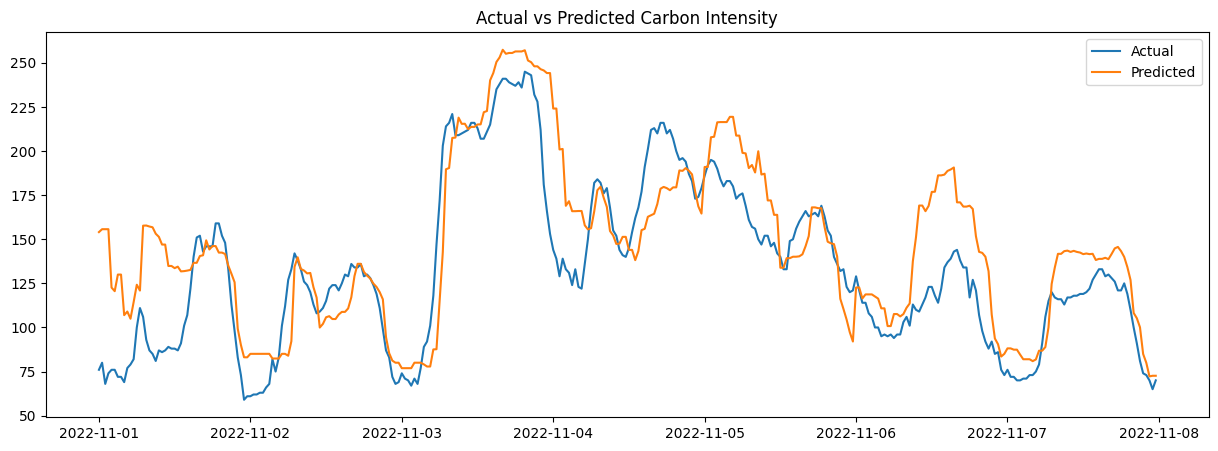

In [9]:
# looking closer at a single week: 
test_data = data_df[data_df.index >= "2022-11-01"].copy()
test_data = test_data[test_data.index < "2022-11-08"]

X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]
X_test = scaler.transform(X_test)

predictions = reg.predict(X_test)


# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()

Over a week of the first week of the test set, we can see that it does not start strong. However the general trend of carbon intensity is followed. 


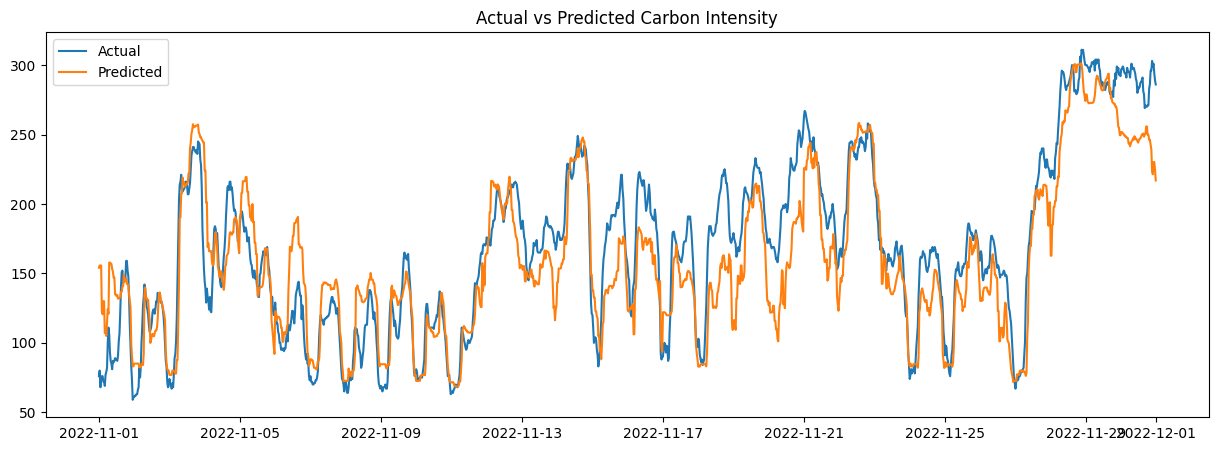

In [10]:
# Plotting the first month: 
test_data = data_df[data_df.index >= "2022-11-01"].copy()
test_data = test_data[test_data.index < "2022-12-01"]

X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]
X_test = scaler.transform(X_test)

predictions = reg.predict(X_test)


# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()


Again, general trend is there, but model has hard time towards the end as it has never seen this sort of increased wind energy production. 


Its quite surprising, that without any time features, the model works already quite well. However still far from the baseline forecast of around 6%. 

Lets now incorporate some time features: 

## 3. XGBoost + Time Features: 


- Some simple time features include day of the week, time, as well as if the day is a holiday. 
- Including month could also be interesting, however the test set months are not present in training so would lead to errors. 
- Time features could also be created by using cosine-sine transformations - But we will not be doing that here. 


Lets first start by adding: 
- minute
- hour
- day of week
- if the day is a weekend

In [11]:
train_data = data_df[data_df.index < split_date].copy()
test_data = data_df[data_df.index >= split_date].copy()


fold = 0
preds = []
scores = []
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

# Only normalise numerical columns:
cols_to_normalize = ["demand", "solar", "wind_onshore", "wind_offshore"]
scaler = StandardScaler()

for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    val = train_data.iloc[val_idx]

    # add date time features
    train = create_date_time_features(train)
    val = create_date_time_features(val)

    # one hot encode
    train = one_hot_encode_cols(train)
    val = one_hot_encode_cols(val)


    # Normalize numerical columns:
    train[cols_to_normalize] = scaler.fit_transform(train[cols_to_normalize])
    val[cols_to_normalize] = scaler.transform(val[cols_to_normalize])


    X_train, y_train = train.drop(columns=["carbon_intensity_actual"]), train["carbon_intensity_actual"]
    X_val, y_val = val.drop(columns=["carbon_intensity_actual"]), val["carbon_intensity_actual"]

    reg = xgb.XGBRegressor( 
                           n_estimators=100, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           early_stopping_rounds=50,
                           eval_metric="rmse",
                           reg_alpha=0.1,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )
    reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)
    print(f"Fold {fold + 1}, RMSE: {score:.5}")


print(f"Mean of cross validation RMSE is {np.mean(scores):.5} gCO₂/kWh.")


[0]	validation_0-rmse:62.97374	validation_1-rmse:52.40199


[90]	validation_0-rmse:19.51818	validation_1-rmse:25.74661
Fold 1, RMSE: 24.985
[0]	validation_0-rmse:61.40339	validation_1-rmse:56.72646
[99]	validation_0-rmse:19.69785	validation_1-rmse:31.13644
Fold 1, RMSE: 31.136
[0]	validation_0-rmse:60.60167	validation_1-rmse:58.55100
[99]	validation_0-rmse:20.66912	validation_1-rmse:25.55802
Fold 1, RMSE: 25.558
[0]	validation_0-rmse:60.10668	validation_1-rmse:63.08319
[99]	validation_0-rmse:20.73098	validation_1-rmse:36.98252
Fold 1, RMSE: 36.964
[0]	validation_0-rmse:60.37907	validation_1-rmse:62.33083
[99]	validation_0-rmse:22.15193	validation_1-rmse:27.42918
Fold 1, RMSE: 27.297
Mean of cross validation RMSE is 29.188 gCO₂/kWh.


RMSE on test set is 34.429 gCO₂/kWh.
Mean Absolute Percentage Error on test set is 21.7%.


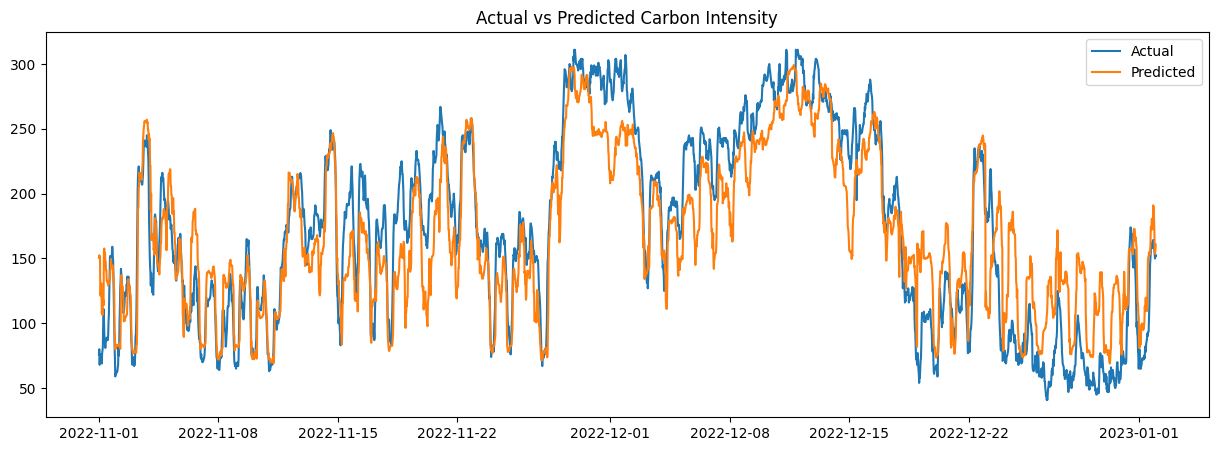

In [12]:
train_data = data_df[data_df.index < split_date].copy()
test_data = data_df[data_df.index >= split_date].copy()

X_train, y_train = train_data.drop(columns=["carbon_intensity_actual"]), train_data["carbon_intensity_actual"]
X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]

X_train = create_date_time_features(X_train)
X_test = create_date_time_features(X_test)

X_train = one_hot_encode_cols(X_train)
X_test = one_hot_encode_cols(X_test)

# scaler = StandardScaler()
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

reg = xgb.XGBRegressor( 
                           n_estimators=100, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           eval_metric="rmse",
                           reg_alpha=0.01,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )
reg = reg.fit(X_train, y_train,
                verbose=None,
)


predictions = reg.predict(X_test)
score = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test set is {score:.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error on test set is {mape*100:.3}%.")

# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()




- Adding minute and hour increased scores by less than 1%. 
- Adding day of the week worsened the results by 1%. 
- Adding if today is a holiday does not seem to increse score either. 
- For now we will then only include hour and minutes. 

## 3. XGBoost + Time Features + Lag Features:

Create features from previous days

Best way of finding insigthful lags would be through auto-corelation. However for simplicity purposes lets just pick a couple previous days. 

In [13]:
# setup lag features for the model spanning 1, 2, 3, 4, 5 Days: 
def create_lag_features(df, column, lag):
    """
    Create lag features for a specified column.
    """
    df = df.copy()
    df[f"{column}_lag_{lag}"] = df[column].shift(lag)
    return df


# Create Dataframe with lag features: 
data_df_lags_1_day = data_df.copy()

cols_to_add_lags = ["demand", "solar", "wind_onshore", "wind_offshore", "carbon_intensity_actual"]
for col in cols_to_add_lags:
    data_df_lags_1_day = create_lag_features(data_df_lags_1_day, col, 48)



# Drop NaN values generated by lags: 
data_df_lags_1_day = data_df_lags_1_day.dropna()

data_df_lags_1_day



,carbon_intensity_actual,demand,solar,wind_offshore,wind_onshore,demand_lag_48,solar_lag_48,wind_onshore_lag_48,wind_offshore_lag_48,carbon_intensity_actual_lag_48
Date,,,,,,,,,,
2022-01-02 00:00:00,44.0,20000,0.0,7623.033,6633.088,21690.0,0.0,4739.050,6480.583,74.0
2022-01-02 00:30:00,47.0,20200,0.0,7623.033,6633.088,21830.0,0.0,4739.050,6480.583,75.0
2022-01-02 01:00:00,50.0,19831,0.0,7463.181,6543.203,21335.0,0.0,5380.218,6708.648,73.0
2022-01-02 01:30:00,50.0,19168,0.0,7463.181,6543.203,20239.0,0.0,5380.218,6708.648,68.0
2022-01-02 02:00:00,47.0,18648,0.0,7433.694,6466.197,19224.0,0.0,6059.516,6978.515,71.0
...,...,...,...,...,...,...,...,...,...,...
2023-01-01 21:30:00,156.0,26661,0.0,7365.071,2085.645,25301.0,0.0,3509.794,8603.428,92.0
2023-01-01 22:00:00,153.0,25531,0.0,7016.521,2053.780,23468.0,0.0,3645.832,9162.634,90.0
2023-01-01 22:30:00,150.0,24623,0.0,7016.521,2053.780,22790.0,0.0,3645.832,9162.634,79.0


### Running with 1 Day lags: 

In [14]:
train_data = data_df_lags_1_day[data_df_lags_1_day.index < split_date].copy()
test_data = data_df_lags_1_day[data_df_lags_1_day.index >= split_date].copy()


fold = 0
preds = []
scores = []
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

# Only normalise numerical columns:
cols_to_normalize = train_data.drop(columns=["carbon_intensity_actual"]).columns

scaler = StandardScaler()

for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    val = train_data.iloc[val_idx]

    # add date time features
    train = create_date_time_features(train)
    val = create_date_time_features(val)

    # one hot encode
    train = one_hot_encode_cols(train)
    val = one_hot_encode_cols(val)


    # Normalize numerical columns:
    train[cols_to_normalize] = scaler.fit_transform(train[cols_to_normalize])
    val[cols_to_normalize] = scaler.transform(val[cols_to_normalize])


    X_train, y_train = train.drop(columns=["carbon_intensity_actual"]), train["carbon_intensity_actual"]
    X_val, y_val = val.drop(columns=["carbon_intensity_actual"]), val["carbon_intensity_actual"]

    reg = xgb.XGBRegressor( 
                           n_estimators=300, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           early_stopping_rounds=50,
                           eval_metric="rmse",
                           reg_alpha=0.01,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )
    reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)
    print(f"Fold {fold + 1}, RMSE: {score:.5}")


print(f"Mean of cross validation RMSE is {np.mean(scores):.5} gCO₂/kWh.")


[0]	validation_0-rmse:62.55985	validation_1-rmse:52.38533


[98]	validation_0-rmse:15.28222	validation_1-rmse:24.21849
Fold 1, RMSE: 23.912
[0]	validation_0-rmse:61.02144	validation_1-rmse:56.40559
[100]	validation_0-rmse:15.80940	validation_1-rmse:26.61326
[200]	validation_0-rmse:13.21914	validation_1-rmse:25.39699
[299]	validation_0-rmse:11.61653	validation_1-rmse:24.91572
Fold 1, RMSE: 24.916
[0]	validation_0-rmse:60.23604	validation_1-rmse:58.14813
[100]	validation_0-rmse:16.38625	validation_1-rmse:21.84453
[200]	validation_0-rmse:13.72767	validation_1-rmse:20.99211
[299]	validation_0-rmse:12.33544	validation_1-rmse:20.86712
Fold 1, RMSE: 20.867
[0]	validation_0-rmse:59.73514	validation_1-rmse:62.90494
[100]	validation_0-rmse:16.31071	validation_1-rmse:30.82633
[200]	validation_0-rmse:13.85893	validation_1-rmse:29.42961
[299]	validation_0-rmse:12.36721	validation_1-rmse:29.12223
Fold 1, RMSE: 29.122
[0]	validation_0-rmse:60.04096	validation_1-rmse:62.61670
[100]	validation_0-rmse:17.11973	validation_1-rmse:25.59405
[146]	validation_0-rmse:1

RMSE on test set is 28.87 gCO₂/kWh.
Mean Absolute Percentage Error on test set is 18.1%.


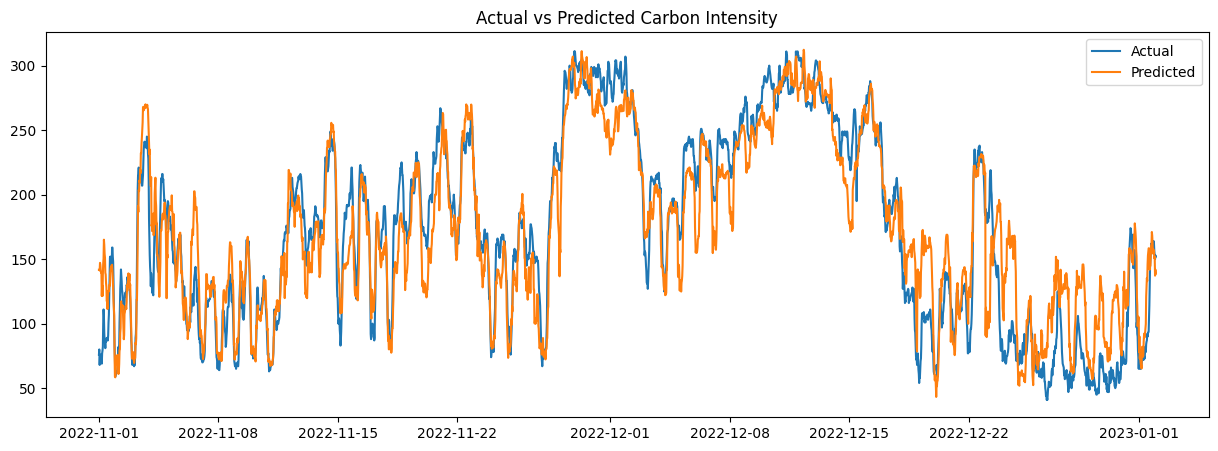

In [15]:
train_data = data_df_lags_1_day[data_df_lags_1_day.index < split_date].copy()
test_data = data_df_lags_1_day[data_df_lags_1_day.index >= split_date].copy()

X_train, y_train = train_data.drop(columns=["carbon_intensity_actual"]), train_data["carbon_intensity_actual"]
X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]

X_train = create_date_time_features(X_train)
X_test = create_date_time_features(X_test)

X_train = one_hot_encode_cols(X_train)
X_test = one_hot_encode_cols(X_test)

# scaler = StandardScaler()
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

reg = xgb.XGBRegressor( 
                    n_estimators=300, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    random_state=123, 
                    eval_metric="rmse",
                    reg_alpha=0.01,  # L1 regularization
                    reg_lambda=0.01   # L2 regularization
                    )
reg = reg.fit(X_train, y_train,
                verbose=None,
)


predictions = reg.predict(X_test)
score = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test set is {score:.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error on test set is {mape*100:.3}%.")

# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()




Adding lag features definitly improved the model performance by around 3% 

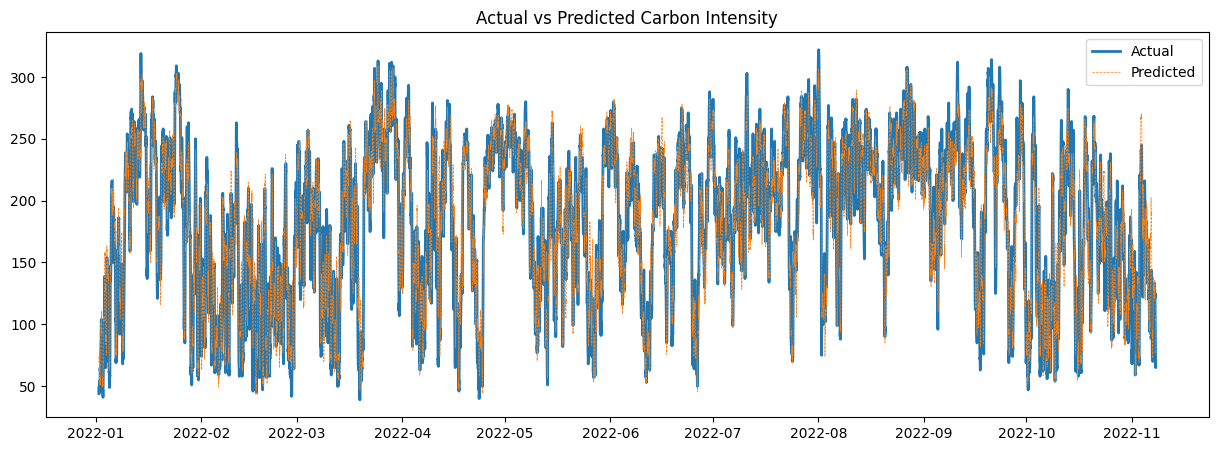

In [16]:
# looking closer at a single week: 
test_data = data_df_lags_1_day[data_df_lags_1_day.index >= "2022-11-01"].copy()
test_data = data_df_lags_1_day[data_df_lags_1_day.index < "2022-11-08"]

# Add date time features:
test_data = create_date_time_features(test_data)
test_data = one_hot_encode_cols(test_data)

X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

predictions = reg.predict(X_test)


# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual", linewidth=2)
plt.plot(test_data.index, predictions, label="Predicted", linestyle="--",linewidth=0.5)
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()

Not the best visualisation but we can notice that this model captures good local changes too. 

### Lets add some more Lags: 

Adding more lags showed worsening improvements. Probably as the data shows seasonal tendencies, values from previous days, weeks lose information. 

An interesting observation was noticed when not adding wind_offshore in the lags: 

- Interesting observation and could mean that offshore wind production may not contain that much importance to the prediction


In [17]:
data_df_lags_1_day = data_df.copy()

cols_to_add_lags = ["demand", "solar", "wind_onshore", "carbon_intensity_actual"]
for col in cols_to_add_lags:
    data_df_lags_1_day = create_lag_features(data_df_lags_1_day, col, 48)



# Drop NaN values generated by lags: 
data_df_lags_1_day = data_df_lags_1_day.dropna()
data_df_lags_1_day

,carbon_intensity_actual,demand,solar,wind_offshore,wind_onshore,demand_lag_48,solar_lag_48,wind_onshore_lag_48,carbon_intensity_actual_lag_48
Date,,,,,,,,,
2022-01-02 00:00:00,44.0,20000,0.0,7623.033,6633.088,21690.0,0.0,4739.050,74.0
2022-01-02 00:30:00,47.0,20200,0.0,7623.033,6633.088,21830.0,0.0,4739.050,75.0
2022-01-02 01:00:00,50.0,19831,0.0,7463.181,6543.203,21335.0,0.0,5380.218,73.0
2022-01-02 01:30:00,50.0,19168,0.0,7463.181,6543.203,20239.0,0.0,5380.218,68.0
2022-01-02 02:00:00,47.0,18648,0.0,7433.694,6466.197,19224.0,0.0,6059.516,71.0
...,...,...,...,...,...,...,...,...,...
2023-01-01 21:30:00,156.0,26661,0.0,7365.071,2085.645,25301.0,0.0,3509.794,92.0
2023-01-01 22:00:00,153.0,25531,0.0,7016.521,2053.780,23468.0,0.0,3645.832,90.0
2023-01-01 22:30:00,150.0,24623,0.0,7016.521,2053.780,22790.0,0.0,3645.832,79.0


In [18]:
train_data = data_df_lags_1_day[data_df_lags_1_day.index < split_date].copy()
test_data = data_df_lags_1_day[data_df_lags_1_day.index >= split_date].copy()


fold = 0
preds = []
scores = []
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

# Only normalise numerical columns:
cols_to_normalize = train_data.drop(columns=["carbon_intensity_actual"]).columns

scaler = StandardScaler()

for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    val = train_data.iloc[val_idx]

    # add date time features
    train = create_date_time_features(train)
    val = create_date_time_features(val)

    # one hot encode
    train = one_hot_encode_cols(train)
    val = one_hot_encode_cols(val)


    # Normalize numerical columns:
    train[cols_to_normalize] = scaler.fit_transform(train[cols_to_normalize])
    val[cols_to_normalize] = scaler.transform(val[cols_to_normalize])


    X_train, y_train = train.drop(columns=["carbon_intensity_actual"]), train["carbon_intensity_actual"]
    X_val, y_val = val.drop(columns=["carbon_intensity_actual"]), val["carbon_intensity_actual"]

    reg = xgb.XGBRegressor( 
                           n_estimators=500, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           early_stopping_rounds=50,
                           eval_metric="rmse",
                           reg_alpha=0.1,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )
    reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)
    print(f"Fold {fold + 1}, RMSE: {score:.5}")


print(f"Mean of cross validation RMSE is {np.mean(scores):.5} gCO₂/kWh.")


[0]	validation_0-rmse:62.56414	validation_1-rmse:52.38412


[100]	validation_0-rmse:15.88036	validation_1-rmse:24.07919
[161]	validation_0-rmse:14.21681	validation_1-rmse:24.05040
Fold 1, RMSE: 23.963
[0]	validation_0-rmse:61.02188	validation_1-rmse:56.40823
[100]	validation_0-rmse:16.46053	validation_1-rmse:27.06345
[200]	validation_0-rmse:14.05231	validation_1-rmse:25.94335
[300]	validation_0-rmse:12.55081	validation_1-rmse:25.60008
[400]	validation_0-rmse:11.57130	validation_1-rmse:25.46701
[438]	validation_0-rmse:11.23113	validation_1-rmse:25.51484
Fold 1, RMSE: 25.443
[0]	validation_0-rmse:60.23605	validation_1-rmse:58.14814
[100]	validation_0-rmse:17.00053	validation_1-rmse:22.32447
[200]	validation_0-rmse:14.65133	validation_1-rmse:21.35309
[300]	validation_0-rmse:13.32255	validation_1-rmse:21.36755
[322]	validation_0-rmse:13.08756	validation_1-rmse:21.34515
Fold 1, RMSE: 21.306
[0]	validation_0-rmse:59.73515	validation_1-rmse:62.90494
[100]	validation_0-rmse:17.02138	validation_1-rmse:31.31208
[200]	validation_0-rmse:14.77547	validation

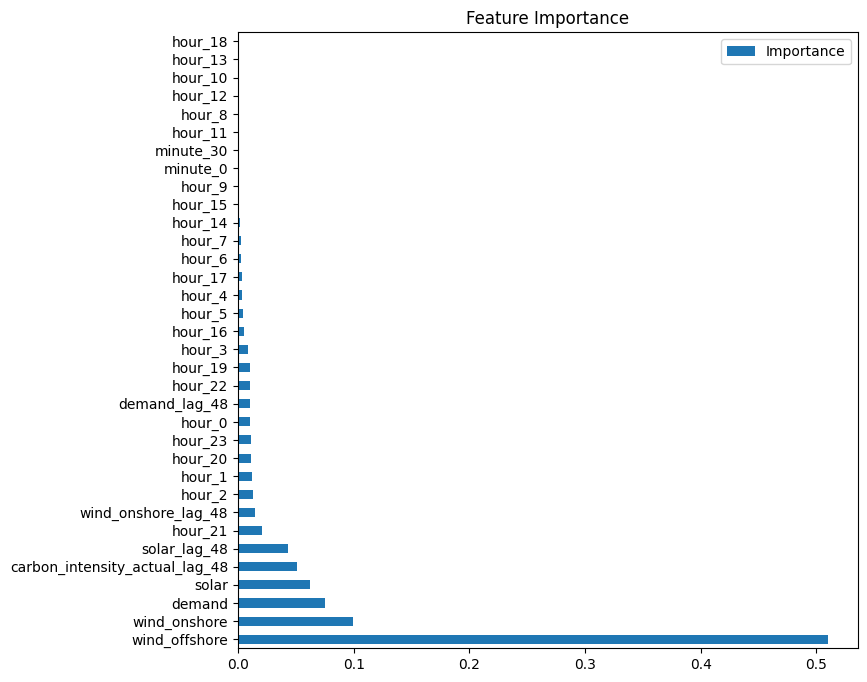

In [19]:
# Look at importance of features:
importances = reg.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
df = pd.DataFrame(importances[indices], index=features[indices], columns=["Importance"])
df = df.sort_values(by="Importance", ascending=False)
df.plot(kind="barh", figsize=(8, 8))
plt.title("Feature Importance")
plt.show()

Looking at the feature importance, we can see that the model really used the offshore wind greatly for its prediction. The reason why removing the lag for it caused such as issues could be because it was adding old information. 

RMSE on test set is 28.78 gCO₂/kWh.
Mean Absolute Percentage Error on test set is 17.1%.


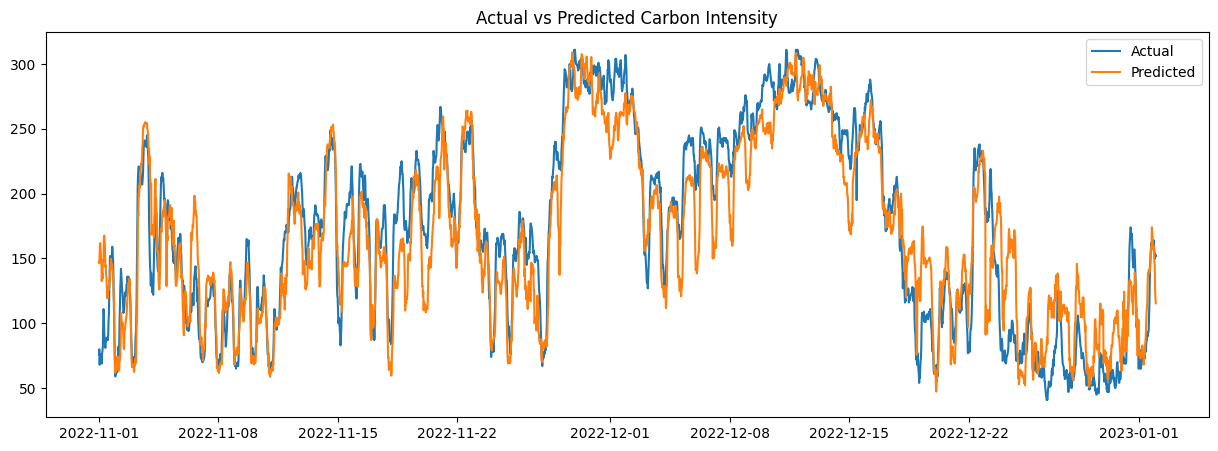

In [20]:
train_data = data_df_lags_1_day[data_df_lags_1_day.index < split_date].copy()
test_data = data_df_lags_1_day[data_df_lags_1_day.index >= split_date].copy()

X_train, y_train = train_data.drop(columns=["carbon_intensity_actual"]), train_data["carbon_intensity_actual"]
X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]

X_train = create_date_time_features(X_train)
X_test = create_date_time_features(X_test)

X_train = one_hot_encode_cols(X_train)
X_test = one_hot_encode_cols(X_test)

# scaler = StandardScaler()
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

reg = xgb.XGBRegressor( 
                    n_estimators=300, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    random_state=123, 
                    eval_metric="rmse",
                    reg_alpha=0.1,  # L1 regularization
                    reg_lambda=0.01   # L2 regularization
                    )
reg = reg.fit(X_train, y_train,
                verbose=None,
)


predictions = reg.predict(X_test)
score = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test set is {score:.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error on test set is {mape*100:.3}%.")

# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()




# Baseline Conclusions: 

We were able to develop a simple XGBoost regressor that is able to predict next day, carbon intensities using forecasted energy production from wind and sun. 


However our model is still not as performant as the baseline. This is likely because we are lacking information about actual fossil fuels being used for the grid - or at least forecasts. 

Therefore lets look into getting some of that data: 



---

# Extra Features and Engineering:

- Initial feature engineering was done with the wind forecasts but have been removed due to worse results. 


## Adding generation Mix forecast data:

This data was collected using the download_generation_mix python script. This uses the Carbonintensity API to download information regarding the predicted genration mix at a certain time. 


We should be able to use this data as it is generated as a forecast from an ensemble of ML models. If this is an issue, then imagine we were able to create a prediction model for this. 

In [ ]:
# load the generation data:
generation_df = pd.read_csv("../data/generation_data.csv", index_col=0)
generation_df.index.name = "Date"
generation_df.index = pd.to_datetime(generation_df.index).tz_localize(None)

# drop other column as it is empty: 
generation_df = generation_df.drop(columns=["other"])

# change column names to gen_mix_{name}:
generation_df.columns = [f"gen_mix_{col}" for col in generation_df.columns]

# Normalise the generation data back down from percentages: 
generation_df = generation_df / 100

# Combine the generation data with the original data:
data_df_with_gen = pd.concat([data_df, generation_df], axis=1)
data_df_with_gen.head(5)



,carbon_intensity_actual,demand,solar,wind_offshore,wind_onshore,gen_mix_biomass,gen_mix_coal,gen_mix_imports,gen_mix_gas,gen_mix_nuclear,gen_mix_hydro,gen_mix_solar,gen_mix_wind
Date,,,,,,,,,,,,,
2022-01-01 00:00:00,74.0,21690,0.0,6480.583,4739.050,0.059,0.0,0.056,0.106,0.264,0.012,0.0,0.503
2022-01-01 00:30:00,75.0,21830,0.0,6480.583,4739.050,0.060,0.0,0.058,0.111,0.265,0.011,0.0,0.495
2022-01-01 01:00:00,73.0,21335,0.0,6708.648,5380.218,0.059,0.0,0.050,0.113,0.261,0.010,0.0,0.506
2022-01-01 01:30:00,68.0,20239,0.0,6708.648,5380.218,0.057,0.0,0.050,0.108,0.256,0.010,0.0,0.519
2022-01-01 02:00:00,71.0,19224,0.0,6978.515,6059.516,0.059,0.0,0.027,0.104,0.263,0.010,0.0,0.536


In [22]:
train_data = data_df_with_gen[data_df_with_gen.index < split_date].copy()
test_data = data_df_with_gen[data_df_with_gen.index >= split_date].copy()


fold = 0
preds = []
scores = []
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    val = train_data.iloc[val_idx]

    X_train, y_train = train.drop(columns=["carbon_intensity_actual"]), train["carbon_intensity_actual"]
    X_val, y_val = val.drop(columns=["carbon_intensity_actual"]), val["carbon_intensity_actual"]

    cols_to_drop = [ "wind_onshore", "wind_offshore"]
    X_train = X_train.drop(columns=cols_to_drop)
    X_val = X_val.drop(columns=cols_to_drop)


    X_train = create_date_time_features(X_train)
    X_val = create_date_time_features(X_val)

    X_train = one_hot_encode_cols(X_train)
    X_val = one_hot_encode_cols(X_val)


    reg = xgb.XGBRegressor( 
                           n_estimators=500, 
                           max_depth=5, 
                           learning_rate=0.05, 
                           random_state=123, 
                           early_stopping_rounds=50,
                           eval_metric="rmse",
                           reg_alpha=0.01,  # L1 regularization
                           reg_lambda=0.01   # L2 regularization
                           )

    reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append(score)
    print(f"Fold {fold + 1}, RMSE: {score:.5}")

print(f"Mean of cross validation RMSE is {np.mean(scores):.5} gCO₂/kWh.")

[0]	validation_0-rmse:62.57599	validation_1-rmse:52.21075


[100]	validation_0-rmse:6.30934	validation_1-rmse:9.41251
[156]	validation_0-rmse:5.63596	validation_1-rmse:9.47654
Fold 1, RMSE: 9.4026
[0]	validation_0-rmse:60.98186	validation_1-rmse:55.91447
[100]	validation_0-rmse:6.61632	validation_1-rmse:9.84902
[167]	validation_0-rmse:5.88574	validation_1-rmse:9.95235
Fold 1, RMSE: 9.8042
[0]	validation_0-rmse:60.15686	validation_1-rmse:57.98725
[100]	validation_0-rmse:6.86133	validation_1-rmse:10.07351
[200]	validation_0-rmse:5.96119	validation_1-rmse:9.46278
[300]	validation_0-rmse:5.57226	validation_1-rmse:9.29391
[400]	validation_0-rmse:5.21858	validation_1-rmse:9.19637
[499]	validation_0-rmse:4.94340	validation_1-rmse:9.13582
Fold 1, RMSE: 9.1322
[0]	validation_0-rmse:59.65520	validation_1-rmse:61.83753
[100]	validation_0-rmse:7.01577	validation_1-rmse:8.51270
[200]	validation_0-rmse:6.17655	validation_1-rmse:8.10252
[300]	validation_0-rmse:5.76292	validation_1-rmse:8.05968
[354]	validation_0-rmse:5.57690	validation_1-rmse:8.06558
Fold 1, 

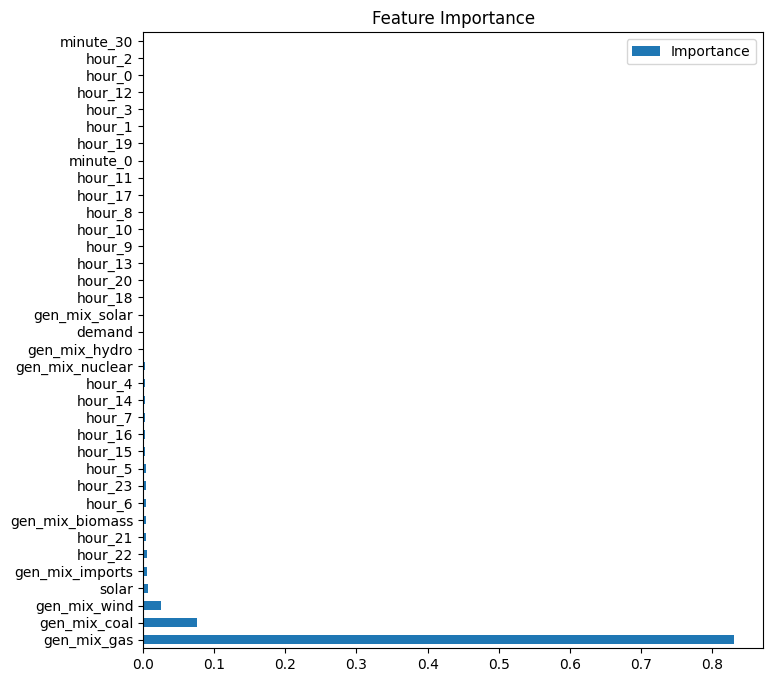

In [23]:
# plot feature importance: 
importances = reg.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
df = pd.DataFrame(importances[indices], index=features[indices], columns=["Importance"])
df = df.sort_values(by="Importance", ascending=False)
df.plot(kind="barh", figsize=(8, 8))
plt.title("Feature Importance")
plt.show()

RMSE on test set is 10.591 gCO₂/kWh.
Mean Absolute Percentage Error on test set is 5.74%.


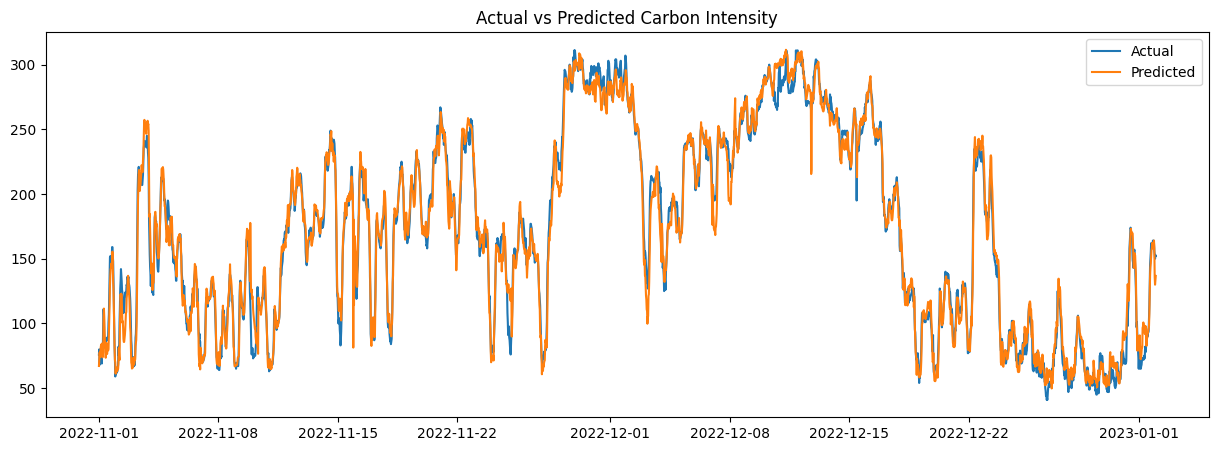

In [24]:
train_data = data_df_with_gen[data_df_with_gen.index < split_date].copy()
test_data = data_df_with_gen[data_df_with_gen.index >= split_date].copy()

X_train, y_train = train_data.drop(columns=["carbon_intensity_actual"]), train_data["carbon_intensity_actual"]
X_test, y_test = test_data.drop(columns=["carbon_intensity_actual"]), test_data["carbon_intensity_actual"]


cols_to_drop = [ "wind_onshore", "wind_offshore"]
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)


X_train = create_date_time_features(X_train)
X_test = create_date_time_features(X_test)

X_train = one_hot_encode_cols(X_train)
X_test = one_hot_encode_cols(X_test)


reg = xgb.XGBRegressor( 
                    n_estimators=500, 
                    max_depth=5, 
                    learning_rate=0.05, 
                    random_state=123, 
                    eval_metric="rmse",
                    reg_alpha=0.1,  # L1 regularization
                    reg_lambda=0.01   # L2 regularization
                    )

reg = reg.fit(X_train, y_train,
                verbose=None,
)


predictions = reg.predict(X_test)
score = root_mean_squared_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test set is {score:.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error on test set is {mape*100:.3}%.")

# plot test set predictions:
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data["carbon_intensity_actual"], label="Actual")
plt.plot(test_data.index, predictions, label="Predicted")
plt.title("Actual vs Predicted Carbon Intensity")
plt.legend()
plt.show()

After some experimentation we noticed that removing both the initial wind estimates lead to the best results. 

#### Lets now add some lags here: 

Adding lags did not lead to significant improvements after adding generation mix forecasts. 

# Simple Conclusions: 


- After modelling with XGBoost and the initial features we were given with lag and date-time features, we were able to achieve a RMSE of 28.8 gCO₂/kWh for carbon intensity regression with 17.1% MAPE. 

- This is a decent result knowing we were predicting a value just by using forecasts of variable which dont have a DIRECT impact on carbon intensity - such as the burning of fossil fuels. 


- After investigating some of the given librairies, I noticed that carbonintensity.org also provides data on the generation mix of the UK. This data not being groud truth, but a forecast, I decided to include it in the model to see if it could improve the predictions.

- This was a great idea, as the RMSE was reduced to 10.6 gCO₂/kWh, with a Mean Absolute Percentage Error of 5.7%, beating the original baseline of around 6.1%. 





# Extra Ideas and Next Steps: 

### MORE DATA: 

- Of course, the scale we were using, we were only training with 10 months of data. Using much more data wouldve have been nice for accurate results and potentially better lag features. But also better testing and generalisation. 


### Autoregressive Prediction:

I wanted to explore autoregressive models but was concerned about error propagation. After reviewing the literature, I found that many people use LSTM models and large ensemble approaches for such tasks, which are effective in handling sequential data.

ref: https://groups.cs.umass.edu/ramesh/wp-content/uploads/sites/3/2022/09/buildsys2022-final282.pdf

### Better Feature Engineering:

- I would have liked to try more statistical models, but after a few attempts with SARIMA, I observed poor results, likely due to stationarity constraints and significant seasonality issues. Additionally, I would have preferred to engineer more features based on correlations between variables for better model performance.

- I also would have liked to implement weather forecasts, as they would include useful insights for next day prediction. 


